In [1]:
# Set environmental variables with google service credentials
import os
%env GOOGLE_APPLICATION_CREDENTIALS=/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json
print(os.getenv('GOOGLE_APPLICATION_CREDENTIALS'))

env: GOOGLE_APPLICATION_CREDENTIALS=/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json
/home/yexi/interview_questions/ntuc_iowa_liquor/bq_sql_key.json


In [2]:
# import necessary libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from google.cloud import bigquery

bqclient = bigquery.Client()

In [3]:
# Test BQ Connect
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

implicit()

[]


### Long Term Alcohol Sales Timeseries (2012-Present)

In [4]:
# Download query results.
liquor_sales_timeseries = """
SELECT 
    DATE_TRUNC(date, month) AS year_month,
    SUM(sale_dollars) AS total_sales,
    SUM(volume_sold_liters) AS total_liters,
    COUNT(invoice_and_item_number) AS num_sold,
    SUM(sale_dollars) / COUNT(invoice_and_item_number) AS avg_invoice_value
FROM `bigquery-public-data.iowa_liquor_sales.sales`
GROUP BY year_month
ORDER BY year_month DESC
"""

liquor_sales_timeseries = (
    bqclient.query(liquor_sales_timeseries)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)

In [5]:
liquor_sales_timeseries['date'] = pd.to_datetime(liquor_sales_timeseries['year_month'], format='%Y-%m-%d')

<AxesSubplot:xlabel='date', ylabel='avg_invoice_value'>

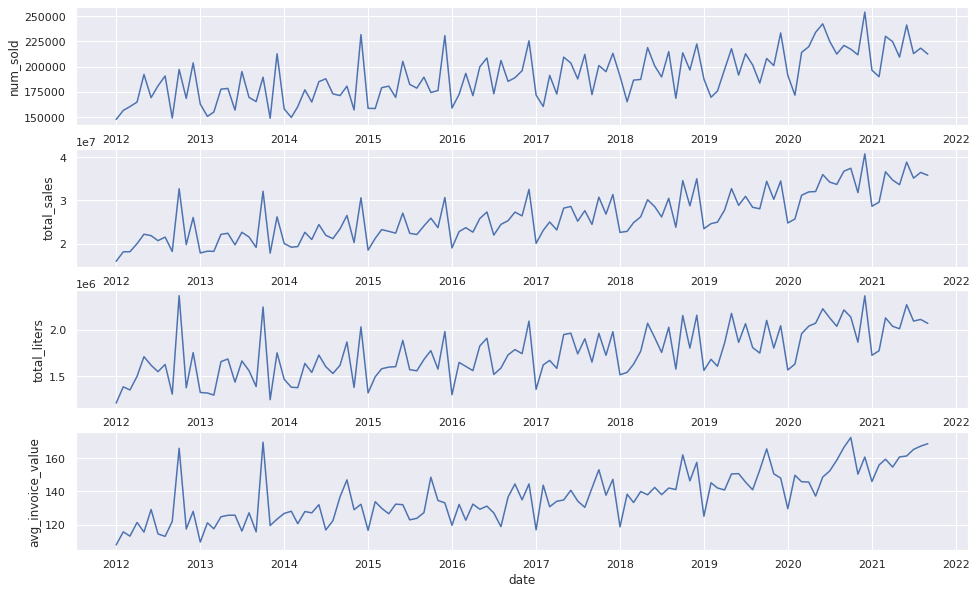

In [6]:
# plot time series
sns.set(rc={'figure.figsize':(16,10)})
fig, axs = plt.subplots(nrows=4)
sns.lineplot(x='date', y='num_sold', data=liquor_sales_timeseries, ax=axs[0])
sns.lineplot(x='date', y='total_sales', data=liquor_sales_timeseries, ax=axs[1])
sns.lineplot(x='date', y='total_liters', data=liquor_sales_timeseries, ax=axs[2])
sns.lineplot(x='date', y='avg_invoice_value', data=liquor_sales_timeseries, ax=axs[3])

**General alcohol sales trend**<br>
Total sales between 2012-2017 has been stable but we start to observe an increase in total sales from 2018 onwards and sales are at an all time high at the end of 2020.

**Seasonality**<br>
We can observe strong seasonality in the dataset. Strong peak in total sales between Oct-Dec periods annually, indicating alcohol sale increase is in-part driven demand rising during traditional holidays such as Halloween (Oct), Thanks-giving(Nov), Christmas and New Years Day in december.

**Liters sold and invoice value (basket value)**<br>
Average invoice value and total liters sold also follow the same trend, indicating sales increase are a result of increased alcohol consumption (in liters)

### Alcohol Category Performance by County

In [7]:
# Download query results.
liquor_sales_timeseries = """
SELECT
    DATE_TRUNC(date, month) AS year_month,
    category_name,
    county,
    SUM(sale_dollars) AS total_sales
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date >= '2018-01-01'
    AND category_name IS NOT NULL
GROUP BY year_month, category_name, county
ORDER BY total_sales DESC
"""

liquor_category_timeseries = (
    bqclient.query(liquor_sales_timeseries)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)

In [8]:
liquor_category_timeseries['date'] = pd.to_datetime(liquor_category_timeseries['year_month'], format='%Y-%m-%d')

## **Data cleaning of alcohol categories**  
Cleaning up over 60 unique categories of alcohol categories and combine same categories with and without "s" at the end to make analysis more managable

In [9]:
# Import process from fuzzywuzzy
from fuzzywuzzy import process

### Using word extract to find text similarity threshold score

In [10]:
# Create list of unique category types
unique_types  = liquor_category_timeseries['category_name'].unique()

# Inspect visually each category to find threshold of text similarity
alcohol_categories = ['Vodka', 'Whiskey', 'Scotch', 'Gin', 'Rum', 'Specialty', 'Cordials']

for category in alcohol_categories:
    # create a set of possible matches for each category
    possible_matches = process.extract(category, unique_types, limit = len(unique_types))
    print(f"========{category}==========")
    print(possible_matches)

========Vodka==========
[('American Vodkas', 90), ('Imported Vodkas', 90), ('Imported Flavored Vodka', 90), ('American Flavored Vodka', 90), ('Imported Vodka', 90), ('American Vodka', 90), ('Imported Cordials & Liqueurs', 54), ('Flavored Rum', 54), ('American Cordials & Liqueur', 54), ('Neutral Grain Spirits Flavored', 54), ('Imported Cordials & Liqueur', 54), ('Flavored Gin', 54), ('American Cordials & Liqueurs', 54), ('Iowa Distilleries', 38), ('Canadian Whiskies', 36), ('Imported Brandies', 36), ('Cocktails /RTD', 36), ('Temporary & Specialty Packages', 36), ('Temporary &  Specialty Packages', 36), ('Special Order Items', 36), ('Aged Dark Rum', 36), ('Gold Rum', 36), ('Iowa Distillery Whiskies', 36), ('Cocktails / RTD', 36), ('Delisted / Special Order Items', 36), ('Temporary  & Specialty Packages', 36), ('Imported Dry Gins', 34), ('Bottled in Bond Bourbon', 34), ('Imported Gins', 34), ('Imported Schnapps', 27), ('Imported Whiskies', 27), ('Mixto Tequila', 22), ('Corn Whiskies', 22)

In [11]:
# **Thresholds**  
# Vodka >= 90  
# Whiskey >= 70  
# Scotch >= 90  
# Gin >= 90  
# Rum >= 90  
# Cordials >= 90  
# Specialty >= 70  

# Create a copy of time series with only category name column
liquor_category = liquor_category_timeseries['category_name'].copy()

categories = ['Vodka', 'Whiskey', 'Scotch', 'Gin', 'Rum', 'Specialty', 'Cordials']

for category in categories:
    # create a set of possible matches for each category
    possible_matches = process.extract(category, unique_types, limit = len(unique_types))
    for match in possible_matches:
        if category == 'Vodka' and match[1] >= 90:
            liquor_category.iloc[liquor_category == match[0]] = category
        elif category == 'Whiskey' and match[1] >= 70:
            liquor_category.iloc[liquor_category == match[0]] = category
        elif category == 'Scotch' and match[1] >= 90:
            liquor_category.iloc[liquor_category == match[0]] = category
        elif category == 'Gin' and match[1] >= 90:
            liquor_category.iloc[liquor_category == match[0]] = category
        elif category == 'Rum' and match[1] >= 90:
            liquor_category.iloc[liquor_category == match[0]] = category
        elif category == 'Specialty' and match[1] >= 90:
            liquor_category.iloc[liquor_category == match[0]] = category
        elif category == 'Cordials' and match[1] >= 90:
            liquor_category.iloc[liquor_category == match[0]] = category

# Set all other category to 'others'
liquor_category.loc[~liquor_category.isin(alcohol_categories)] = 'Others'

# Create a new column with cleaned categories
liquor_category_timeseries['liquor_category'] = liquor_category

In [12]:
# Inspect final result
liquor_category.unique()

array(['Vodka', 'Whiskey', 'Others', 'Rum', 'Cordials', 'Specialty',
       'Scotch', 'Gin'], dtype=object)

## Identifying the top X counties out of 132 that is driving 80% of the sales (pareto rule)

In [13]:
# Download query results.
liquor_sales_timeseries = """
WITH county_sales AS (SELECT
    county,
    SUM(sale_dollars) AS total_sales
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date >= '2018-01-01'
    AND category_name IS NOT NULL
    AND county IS NOT NULL
GROUP BY county
ORDER BY total_sales DESC),
interim_table AS (
SELECT 
    county, 
    total_sales, 
    total_sales / SUM(total_sales) OVER() AS pct
FROM county_sales
ORDER BY 2)

SELECT 
    county, 
    total_sales,
    pct,
    SUM(pct) OVER (ORDER BY total_sales DESC) AS cum_total
FROM interim_table
"""

top_sales_by_county = (
    bqclient.query(liquor_sales_timeseries)
    .result()
    .to_dataframe(
        create_bqstorage_client=True,
    )
)

In [14]:
top_sales_by_county.set_index('county').head(30).style.apply(lambda x: ['background: yellow' 
                                  if (x.name == 'WASHINGTON')
                                  else '' for i in x], axis=1)

,total_sales,pct,cum_total
county,,,
POLK,292164992.389989,0.210524,0.210524
LINN,118690546.850000,0.085525,0.296049
SCOTT,99547555.999997,0.071731,0.367780
JOHNSON,80522480.289998,0.058022,0.425802
BLACK HAWK,75479166.719999,0.054388,0.480189
POTTAWATTA,49524528.430001,0.035686,0.515875
WOODBURY,47751954.930001,0.034408,0.550284
STORY,41883693.120001,0.030180,0.580464
DUBUQUE,41354596.570000,0.029799,0.610262


## The top 26 (19.6%) of counties drive 80% of the total alcohol sales which is consistent with the 80/20 rule
Recommend focusing on growth in the top 20% of counties and analyze growth opportunities from there

In [15]:
# Identify top 20 counties
top_20_pct_counties_series = liquor_category_timeseries.groupby('county')['total_sales'].sum().sort_values(ascending=False).head(27)

# Convert to list for filter later
top_20_pct_counties = top_20_pct_counties_series.reset_index()['county'].to_list()

# Filter data frame for only top 20% counties
top_20_pct_county_cat_timeseries = liquor_category_timeseries[liquor_category_timeseries['county'].isin(top_20_pct_counties)]
top_20_pct_county_cat_timeseries['year_month'] = pd.to_datetime(top_20_pct_county_cat_timeseries['year_month'], format='%Y-%m-%d')

## Find counties with highest YoY grwoth between 2018-2020

In [16]:
# Create year column
top_20_pct_county_cat_timeseries['year'] = top_20_pct_county_cat_timeseries['year_month'].dt.year

In [17]:
# Create pivt table of sales by year and county
county_sales_by_year =  pd.pivot_table(
    data=top_20_pct_county_cat_timeseries,
    index='county',
    columns='year',
    values='total_sales',
    aggfunc=np.sum
).reset_index()

In [18]:
# iterate  over dataframe to identify high YoY growth in each county
county = []
yoy_18_19 = []
yoy_19_20 = []
avg_yoy = []

for index, row in county_sales_by_year.iterrows():
    county.append(row['county'])
    yoy_18_19.append(row[2018]/row[2019] - 1)
    yoy_19_20.append(row[2020]/row[2019] - 1)
    avg_yoy.append(((row[2018]/row[2019] - 1) + (row[2020]/row[2019] - 1))/2)

# create dataframe to identify top grwth counties YoY
county_yoy_growth = pd.DataFrame(
    {
        'county': county,
        'yoy_18_19': yoy_18_19,
        'yoy_19_20': yoy_19_20,
        'avg_yoy': avg_yoy
    }
)

In [19]:
def cond_formatting(cell_value):
    highlight_red = 'background-color: red;'
    highlight_green = 'background-color: green;'
    default = ''
    if type(cell_value) in [float, int]:
        if cell_value < 0:
            return highlight_red
        elif cell_value > 0.2:
            return highlight_green
    return default

county_yoy_growth.sort_values(by='yoy_19_20', ascending=False).style.applymap(cond_formatting)


,county,yoy_18_19,yoy_19_20,avg_yoy
9,Dallas,-0.095423,0.409684,0.157130
3,CERRO GORD,-0.146044,0.409640,0.131798
23,WARREN,-0.052650,0.352689,0.150019
10,JASPER,-0.089652,0.344540,0.127444
5,DALLAS,-0.112139,0.320181,0.104021
24,WASHINGTON,-0.018471,0.286264,0.133896
6,DES MOINES,-0.038049,0.240015,0.100983
14,MARION,-0.086849,0.215855,0.064503
21,STORY,-0.029070,0.215618,0.093274
22,WAPELLO,-0.075451,0.200088,0.062318


**Highest growth counties**  
Majority of counties are in negative growth in total sales (red) between 2018-19 YoY. The trend flipped in 2019-2020 with only 1 county seeing negative growth in sales. The "green" cells indicate above average growth in YoY 2019-2020. We can narrow these 11 counties and breakdown top alcohol categories in each county.

In [43]:
# create list of top 10 counties
top_growth_potential_counties = county_yoy_growth[county_yoy_growth['yoy_19_20'] > 0.2]['county'].to_list()

# Create pivot table of top categories per county in the year 2019 & 2020
top_growth_counties_2019 = liquor_category_timeseries[
    (liquor_category_timeseries['county'].isin(top_growth_potential_counties)) & 
    (liquor_category_timeseries['date'].dt.year == 2019)
    ]

top_growth_counties_2020 = liquor_category_timeseries[
    (liquor_category_timeseries['county'].isin(top_growth_potential_counties)) & 
    (liquor_category_timeseries['date'].dt.year == 2020)
    ]

top_cat_by_county_2019 = pd.pivot_table(
    data=top_growth_counties_2019,
    index=['county', 'liquor_category'],
    values='total_sales',
    aggfunc=np.sum
).reset_index()

top_cat_by_county_2020 = pd.pivot_table(
    data=top_growth_counties_2020,
    index=['county', 'liquor_category'],
    values='total_sales',
    aggfunc=np.sum
).reset_index()

In [44]:
combined_2019_2020 = top_cat_by_county_2019.merge(
    top_cat_by_county_2020, 
    left_on=['county','liquor_category'],
    right_on=['county','liquor_category'],
    suffixes=('_2019', '_2020'))

In [45]:
combined_2019_2020['pct_growth'] = (combined_2019_2020['total_sales_2020'] / combined_2019_2020['total_sales_2019']) - 1

## 2020 Sales by Top Counties and Categories

### **Top categories are whiskey, vodka, rum, and others**
We can see that wiskey sales is top among all the high growth county in 2020, with Story topping whiskey sales at 4.6 Mil dollars.

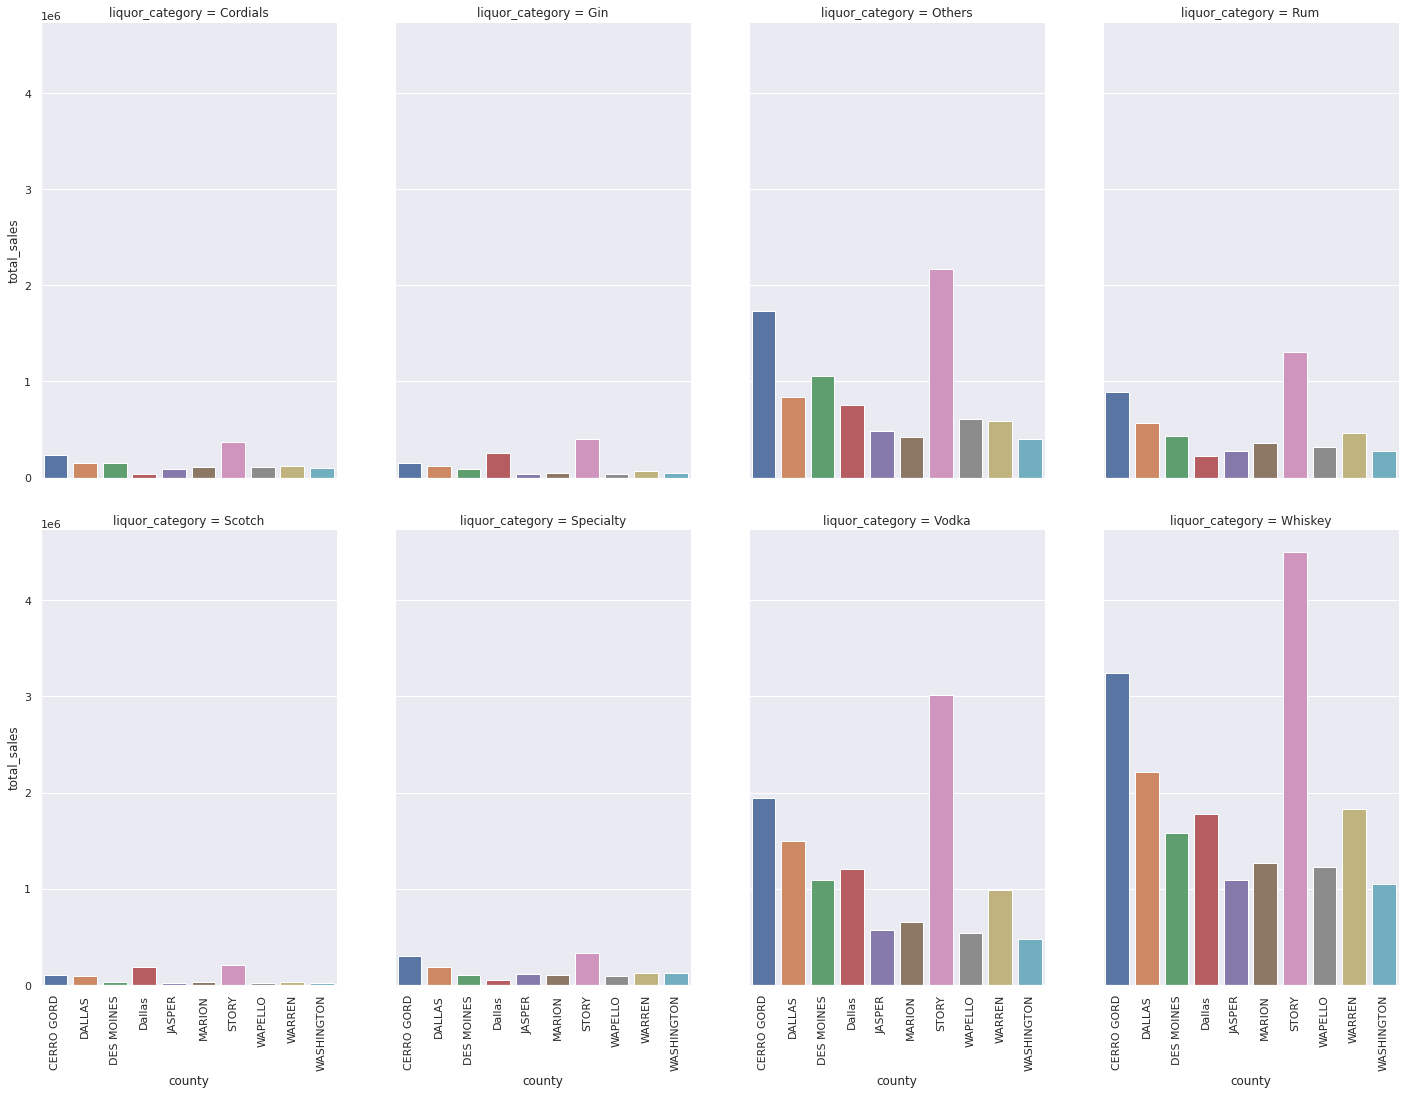

In [64]:
# Plot top categories by county
g = sns.catplot(y="total_sales", x='county', col="liquor_category",
                data=top_cat_by_county_2020, col_wrap=4, kind="bar")
g.set_xticklabels(rotation=90)
g.fig.set_size_inches(20,15)

## 2019-2020 YoY Growth by Top Counties and Categories

### **Top Growth Catgories**
In Dallas we see a 1200% increase in the "Specialty" category. Although top categories such as whiskey and vodka has high sales volume, we see that smaller categories such as specialty, others, scotch and cordials have strong YoY growth too.

In [60]:
# YoY Pct Growth by Category
combined_2019_2020.groupby('liquor_category')['pct_growth'].mean().sort_values(ascending=False).head(20)

liquor_category
Specialty    1.298288
Others       0.496944
Scotch       0.346967
Cordials     0.333505
Whiskey      0.309820
Rum          0.247016
Gin          0.239252
Vodka        0.217237
Name: pct_growth, dtype: float64

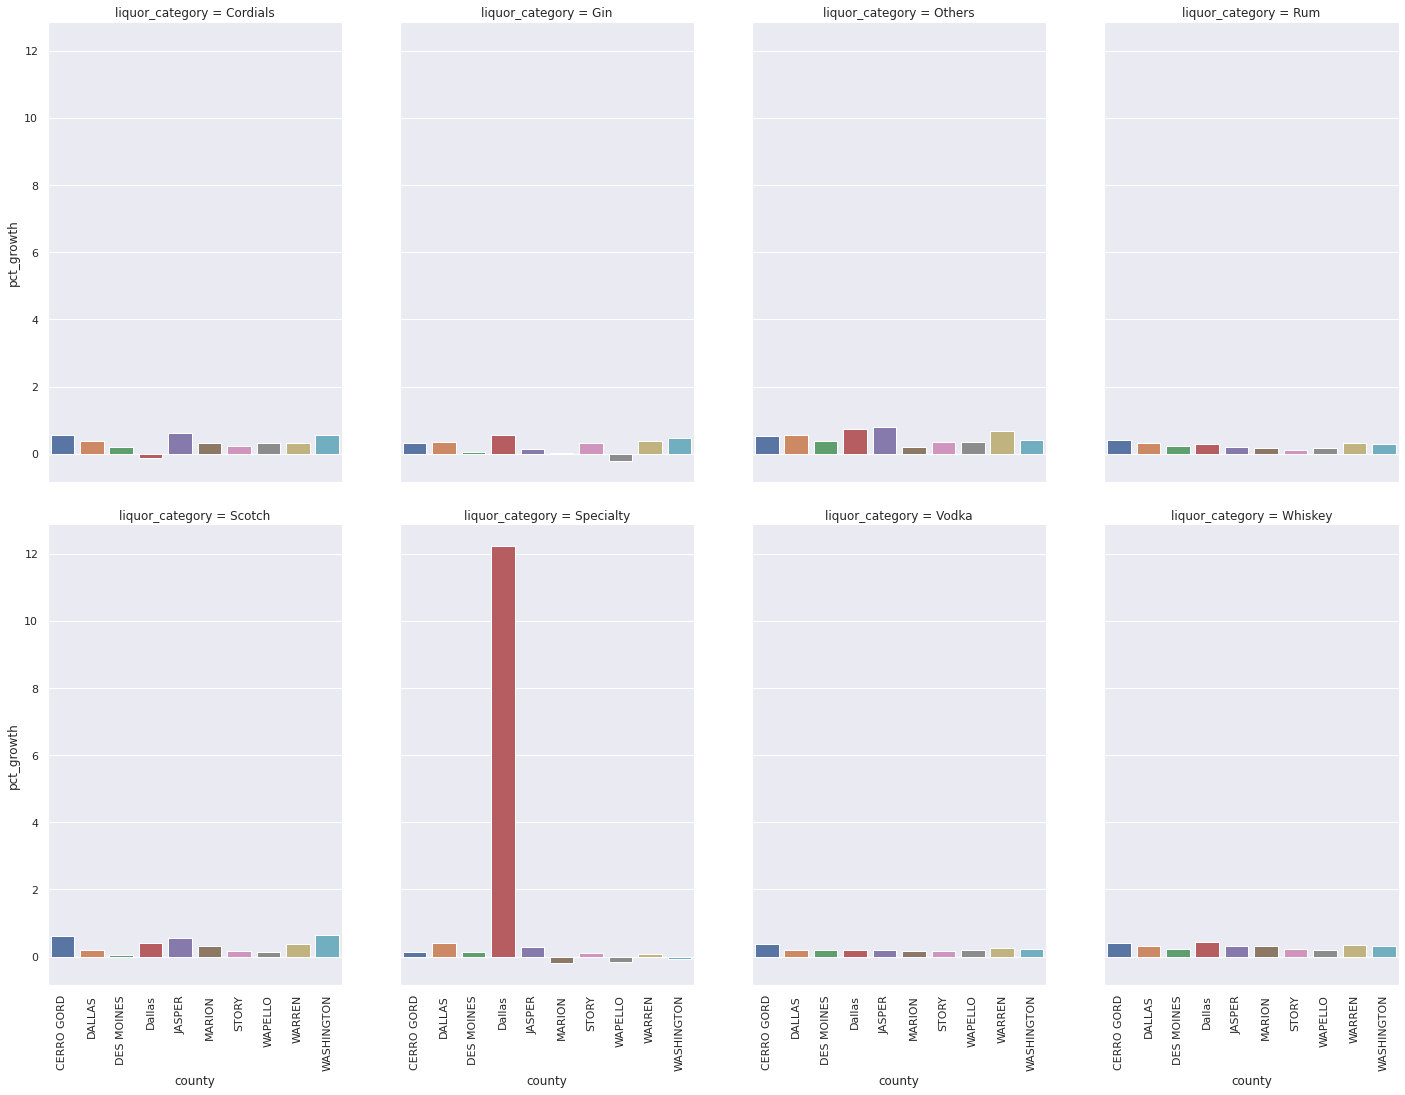

In [62]:
# Plot top categories by county
g = sns.catplot(y="pct_growth", x='county', col="liquor_category",
                data=combined_2019_2020, col_wrap=4, kind="bar")
g.set_xticklabels(rotation=90)
g.fig.set_size_inches(20,15)